# Large-Scale Image Processing On Your Laptop (and elsewhere)

### ImageXD 2017 Tutorial

---
### Goals of this workshop:

* get acquanted with the Python [Dask](http://dask.pydata.org/en/latest/) Library
* learn how to execute basic operations on large images which cannot fit in RAM
* learn about the concepts of lazy evaluation and task scheduling graphs
* learn how to work with [Dask Arrays](http://dask.pydata.org/en/latest/array.html)
* learn how to work with [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html)

---
### Motivation

What is this tutorial about? Researchers across domains get overloaded with image data which their traditional processing workflows are incapable to handle. Usually they are faced with two possible options: 
* move the processing to large machines/clusters
* modify their methods to access the image data only pieces at a time.

<!---* Mechanical Engineering - microbubbles
* Oceanography - sonar, video
* Neuroscience - calcium imaging, fMRI
* etc--->


Scientists like to test out things on their laptops, and later move to clusters, without having to modify their code a lot.

[Dask](http://dask.pydata.org/en/latest/) is a Python Library which makes this possible: 
* can perform computations on images which cannot fit into RAM
* has interface similar to `numpy` and `scipy`
* the same code used on your laptop can be run on a distributed cluster


The Dask library provides several useful objects
* [Dask Arrays](http://dask.pydata.org/en/latest/array.html) (for numpy-like operations) *
* [Dask DataFrames](http://dask.pydata.org/en/doc-test-build/dataframe.html) (for pandas-like operations)
* [Dask Bags](http://dask.pydata.org/en/latest/bag.html) (for unstructured-data-like operations, such as text)
* [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html) (for general functions and operations) *

We will be working with the [cells data](https://github.com/imagexd/imagexd.github.io/blob/master/assets/cells.tar.gz). So set the path to the location where you have unzipped the cells folder.

In [1]:
path = 'cells/'

In [2]:
# some preliminary imports
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Dask Arrays

Dask arrays are similar to numpy arrays, except that they are chunked into small pieces.

In [3]:
import dask.array as da
from dask.array.image import imread

We can read a collection of images into a dask array.

In [4]:
cell_images = imread(path+"*.jpg")

Let's look at it:

In [5]:
cell_images

dask.array<imread-..., shape=(844, 256, 256, 3), dtype=uint8, chunksize=(1, 256, 256, 3)>

In [6]:
# saving the dimensions
T, m, n, d = cell_images.shape

Each image is a separate chunk.

*The images are not loaded into RAM!!!!*

We can do computations on the dask array as long as individual chunks (and the computations on them) fit into RAM.

Let's  find the mean image:

In [7]:
cell_images.mean(axis=0)

dask.array<mean_ag..., shape=(256, 256, 3), dtype=float64, chunksize=(256, 256, 3)>

The above statement creates another dask array, which is not loaded into RAM, i.e. it is not calculated yet. 
It waits for us tell dask explicitly when to do the calculation using the `compute` command.This is called [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation).

In [8]:
%%time
mean_cell_image = cell_images.mean(axis=0).compute()

CPU times: user 10.7 s, sys: 604 ms, total: 11.3 s
Wall time: 5.25 s


In [9]:
type(mean_cell_image)

numpy.ndarray

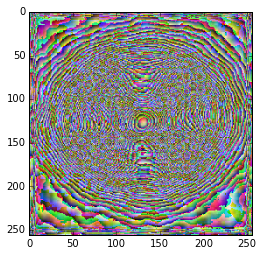

In [10]:
plt.imshow(mean_cell_image)

Well, that is pretty but let's do something more meaningful!

***Important: only the final image is stored in RAM, which is smaller than the original collection!***

Side Note: if we pass a dask array to a function not supporting dask arrays, it often gets converted to an in-memory numpy array and evaluated.

A lot of other functions to perform on images using the [Dask API](http://dask.pydata.org/en/latest/array-api.html).

#### Exercise:
* calculate the mean for each RGB color for each image
* calculate the max for each RGB color for each image
* calculate the min and max across all colors for each image

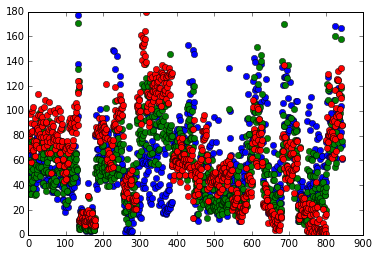

In [11]:
# mean for each RGB color for each image
RGB_means = cell_images.mean(axis=[1,2])
plt.plot(RGB_means,'o')

In [12]:
# max for each color for each image

In [13]:
# min across all colors for each image

In [14]:
# max across all colors for each image

We observe that some of the images have a very diffent intensity range.

#### A simple cell classifier

We can try to use the means of the colors to distinguish between images of differently colored cells.
Let's find the images which have higher green color than red color.

In [17]:
#average green vs average red 
green_labels = (RGB_means[:,0]<RGB_means[:,1]).compute()

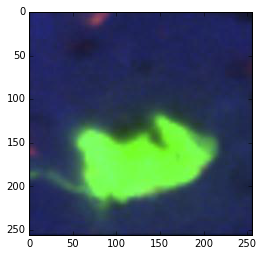

In [18]:
plt.figure()
plt.imshow(cell_images[green_labels,:][3,:,:,:])
plt.show()

Summary:

* dask arrays are not loaded into memory until you start doing computations on them
* computations on dask arrays are not executed until you ask for them via `.compute`()
* passing a `dask.array` to a `numpy` or `matplotlib` function might work but the computation will be done in memory

---
### Perform Principal Component Analysis on a Collection of Images

PCA can be perform by the following steps:
* center the images
* reshape the data into features x observations format
* perform SVD on the data matrix
* reshape the modes into an image format -> they represent the principal components

In [19]:
# center the images
cell_images_centered = cell_images - cell_images.mean(axis = 0)

In [20]:
cell_images_centered

dask.array<sub-704..., shape=(844, 256, 256, 3), dtype=float64, chunksize=(1, 256, 256, 3)>

In [21]:
# create a data matrix - # features x #observations
data = cell_images_centered.reshape((T,m*n*d)).T
print(data.shape)
data

(196608, 844)


dask.array<transpo..., shape=(196608, 844), dtype=float64, chunksize=(196608, 1)>

In [22]:
# svd expects only one column block
data = data.rechunk((256,844))
data

dask.array<rechunk..., shape=(196608, 844), dtype=float64, chunksize=(256, 844)>

In [23]:
u, s, v = da.linalg.svd(data)

In [24]:
%%time
u = u[:,:10].compute()

CPU times: user 4min 24s, sys: 3min 7s, total: 7min 32s
Wall time: 2min 50s


In [25]:
# convert the components to back to images
u = u.reshape(256,256,3,10)

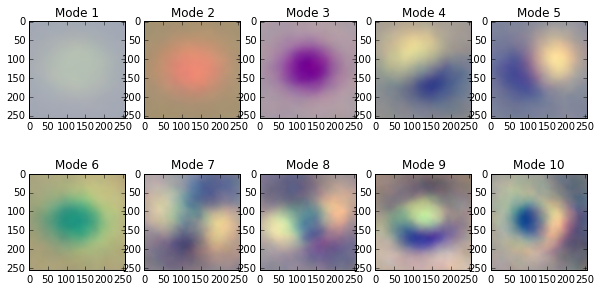

In [26]:
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((u[:,:,:,i]-u.min())/(u.max() - u.min()))
    plt.title('Mode '+str(i+1))

Summary:
* some dask functions are strict about the form of the chunks
* not all familiar methods are implemented within dask, but you can still run them using the existing base functions

#### Extra Exercises

**Exercise: chunking performance**

Try using different chunk sizes and compare the speed of the svd computation.

**Exercise: faster svd**

If you compare to a `scipy` or `scikit-learn` implementations you will notice that the dask svd is a bit slow. The reason is that when the data is too big they do not compute the full `svd` , instead they implement a randomized svd algorithm. Dask has the corresponding implementation in `da.linalg.svd_compressed`.

In [27]:
help(da.linalg.svd_compressed)

Help on function svd_compressed in module dask.array.linalg:

svd_compressed(a, k, n_power_iter=0, seed=None, name=None)
    Randomly compressed rank-k thin Singular Value Decomposition.
    
    This computes the approximate singular value decomposition of a large
    array.  This algorithm is generally faster than the normal algorithm
    but does not provide exact results.  One can balance between
    performance and accuracy with input parameters (see below).
    
    Parameters
    ----------
    a: Array
        Input array
    k: int
        Rank of the desired thin SVD decomposition.
    n_power_iter: int
        Number of power iterations, useful when the singular values
        decay slowly. Error decreases exponentially as n_power_iter
        increases. In practice, set n_power_iter <= 4.
    
    Examples
    --------
    
    >>> u, s, vt = svd_compressed(x, 20)  # doctest: +SKIP
    
    Returns
    -------
    u:  Array, unitary / orthogonal
    s:  Array, singular valu

Run the compressed svd algorithm and compare the execution times.

----
### Performing complex operations on a stack of images.

We consider the following scenario: 

we have a big pile of images and we need to perform the same pre-processing step to each image and in the end store the result in one array for further processing.

Clearly we can achieve this by writing a `for-loop` which processes each image and stores the result. 

To accomplish this in a distributed manner we can use `dask`'s [delayed](http://dask.pydata.org/en/latest/delayed.html) functionality. It allows to parallelize our own Python functions.

In [28]:
from dask import delayed

We recall that the images had different intensity ranges: let's rescale them so that they are always between 0 and 255. We can achieve that with the scikit-image [exposure.rescale_intensity](http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity) funcion.

In [29]:
from skimage.exposure import rescale_intensity

We can convert a regular Python function to a dask delayed function:

In [30]:
rescale_intensity_dask = delayed(rescale_intensity)

In [31]:
# create delayed evaluations
lazy_values = [rescale_intensity_dask(im) for im in cell_images]

In [32]:
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(m,n,d), dtype=cell_images.dtype) for lazy_value in lazy_values]

In [33]:
type(arrays[0])

dask.array.core.Array

We can see that the type of this final result is a list and each entry is a `dask array`:

In [34]:
print(type(arrays))
print(type(arrays[0]))

<class 'list'>
<class 'dask.array.core.Array'>


We can convert them to a dask array:

In [35]:
stack = da.stack(arrays, axis=0) 

In [36]:
stack

dask.array<stack-5..., shape=(844, 256, 256, 3), dtype=uint8, chunksize=(1, 256, 256, 3)>

Note: this chunksize is useful when doing individual operations on images, not across images!

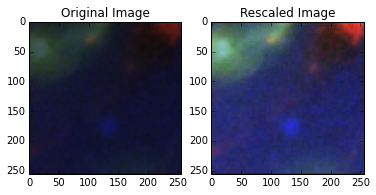

In [37]:
plt.subplot(1,2,1)
plt.imshow(cell_images[100,:,:,:])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(stack[100,:,:,:])
plt.title('Rescaled Image')

In [38]:
RGB_max = stack.max(axis = [1,2,3]).compute()

Now the maximum is always 255.

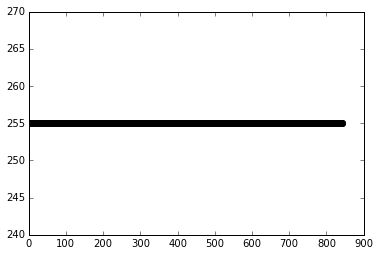

In [39]:
plt.plot(RGB_max,'ko')

#### Extra Exercises

**Exercise: rescaling images**

One approach to segment color images is using the k-means algorithm in color space. The `scikit-image` [`segmentation.slic`](http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic) function is a good candidate:

In [40]:
from skimage import segmentation
help(segmentation.slic)

Help on function slic in module skimage.segmentation.slic_superpixels:

slic(image, n_segments=100, compactness=10.0, max_iter=10, sigma=0, spacing=None, multichannel=True, convert2lab=None, enforce_connectivity=True, min_size_factor=0.5, max_size_factor=3, slic_zero=False)
    Segments image using k-means clustering in Color-(x,y,z) space.
    
    Parameters
    ----------
    image : 2D, 3D or 4D ndarray
        Input image, which can be 2D or 3D, and grayscale or multichannel
        (see `multichannel` parameter).
    n_segments : int, optional
        The (approximate) number of labels in the segmented output image.
    compactness : float, optional
        Balances color proximity and space proximity. Higher values give
        more weight to space proximity, making superpixel shapes more
        square/cubic. In SLICO mode, this is the initial compactness.
        This parameter depends strongly on image contrast and on the
        shapes of objects in the image. We recommend e

Apply the function to each image in the collection using `dask delayed`.

Hint: first test the segmentation on a single image to select appropriate parameters.

Compare the speed of this approach to applying the algorithm through a for loop.

Note: there are alternative approaches to applying a function to a collection of objects in a distributed manner, `dask delayed` is most useful when we want to store the results in a distributed array on which to perform further operations.

#### Exercise: calculating histograms

Use the same approach as above to calculate histogram for each image. In the new array each image is represented by its histogram. You can further try a clustering algorithm to cluster the images based on their histograms.